In [1]:
pip install qiskit qiskit-machine-learning qiskit-algorithms pandas scikit-learn qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [2]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 110.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import pennylane as qml
import torch
import torch.nn as nn

# Load dataset (using SMS Spam Collection)
# Download from: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
df = pd.read_csv('/content/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]  # label, text
df.columns = ['label', 'text']

# Preprocessing
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Feature extraction
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['text']).toarray()
y = df['label'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Spam ratio: {y_train.mean():.3f}")

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


Training set: (4457, 1000)
Test set: (1115, 1000)
Spam ratio: 0.134


In [4]:
# Classical Naive Bayes for comparison
classical_nb = MultinomialNB()
classical_nb.fit(X_train, y_train)
y_pred_classical = classical_nb.predict(X_test)

print("Classical Naive Bayes Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_classical):.4f}")
print(classification_report(y_test, y_pred_classical))

Classical Naive Bayes Results:
Accuracy: 0.9839
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.95      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [5]:
# Quantum device setup
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_probability_circuit(features, weights):
    """
    Quantum circuit to estimate class probabilities
    """
    # Feature encoding - amplitude embedding
    # The 'features' vector must have length 2**n_qubits. Using pad_with=0 to handle shorter vectors.
    qml.AmplitudeEmbedding(features=features, wires=range(n_qubits), normalize=True, pad_with=0)

    # Variational layers for learning
    for i in range(3):
        # Rotation layers
        for j in range(n_qubits):
            qml.Rot(weights[i, j, 0], weights[i, j, 1], weights[i, j, 2], wires=j)

        # Entangling layer
        for j in range(n_qubits-1):
            qml.CNOT(wires=[j, j+1])

    # Measure probabilities
    return qml.probs(wires=range(n_qubits))

class QuantumNaiveBayes:
    def __init__(self, n_qubits=4, n_features=100):
        self.n_qubits = n_qubits
        self.n_features = n_features
        self.class_priors = None
        self.feature_probs = None
        self.quantum_weights = None

    def fit(self, X, y):
        """Train the quantum-enhanced Naive Bayes"""
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Calculate class priors (classical)
        self.class_priors = np.zeros(n_classes)
        for i, cls in enumerate(self.classes):
            self.class_priors[i] = np.sum(y == cls) / n_samples

        # Initialize quantum parameters
        self.quantum_weights = np.random.uniform(0, 2*np.pi,
                                               size=(3, n_qubits, 3))

        # Calculate feature probabilities with quantum enhancement
        self.feature_probs = np.zeros((n_classes, n_features))

        for cls_idx, cls in enumerate(self.classes):
            class_mask = (y == cls)
            X_class = X[class_mask]

            if len(X_class) > 0:
                # Classical probability calculation
                feature_counts = X_class.sum(axis=0) + 1  # Laplace smoothing
                total_count = feature_counts.sum()

                # Quantum enhancement for important features
                important_features = np.argsort(feature_counts)[-n_qubits:]

                for feat_idx in range(n_features):
                    if feat_idx in important_features[:n_qubits]:
                        # Use quantum circuit for important features
                        features_subset = X_class[:, important_features[:n_qubits]]
                        quantum_probs = self._get_quantum_probabilities(
                            features_subset, self.quantum_weights
                        )
                        # Combine classical and quantum probabilities
                        classical_prob = feature_counts[feat_idx] / total_count
                        quantum_prob = np.mean(quantum_probs)
                        self.feature_probs[cls_idx, feat_idx] = (
                            0.7 * classical_prob + 0.3 * quantum_prob
                        )
                    else:
                        # Use classical probability for less important features
                        self.feature_probs[cls_idx, feat_idx] = (
                            feature_counts[feat_idx] / total_count
                        )

        return self

    def _get_quantum_probabilities(self, features, weights):
        """Get probabilities from quantum circuit"""
        probs = []
        for sample in features[:10]:  # Use subset for efficiency
            # The AmplitudeEmbedding expects 2**n_qubits features, sample here is n_qubits.
            # It will be padded to 2**n_qubits inside the qnode due to pad_with=0.
            prob = quantum_probability_circuit(sample, weights)
            probs.append(np.sum(prob))  # Sum probabilities as enhancement factor
        return np.array(probs)

    def predict_proba(self, X):
        """Predict class probabilities"""
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        probabilities = np.zeros((n_samples, n_classes))

        for i in range(n_samples):
            for cls_idx in range(n_classes):
                # Start with class prior
                prob = np.log(self.class_priors[cls_idx])

                # Add feature probabilities (Naive Bayes assumption)
                for feat_idx in range(self.n_features):
                    if X[i, feat_idx] > 0:  # Feature is present
                        prob += np.log(self.feature_probs[cls_idx, feat_idx])

                probabilities[i, cls_idx] = prob

        # Convert log probabilities to normal probabilities
        probabilities = np.exp(probabilities - np.max(probabilities, axis=1, keepdims=True))
        probabilities = probabilities / np.sum(probabilities, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        """Predict class labels"""
        probabilities = self.predict_proba(X)
        return self.classes[np.argmax(probabilities, axis=1)]


In [6]:
# Reduce feature dimension for quantum implementation
n_quantum_features = 100  # Use top 100 features for quantum version
vectorizer_quantum = CountVectorizer(max_features=n_quantum_features, stop_words='english')
X_quantum = vectorizer_quantum.fit_transform(df['text']).toarray()

X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(
    X_quantum, y, test_size=0.2, random_state=42, stratify=y
)

# Train Quantum Naive Bayes
print("Training Quantum Naive Bayes...")
qnb = QuantumNaiveBayes(n_qubits=4, n_features=n_quantum_features)
qnb.fit(X_train_q, y_train_q)

# Predictions
y_pred_quantum = qnb.predict(X_test_q)

print("\nQuantum Naive Bayes Results:")
print(f"Accuracy: {accuracy_score(y_test_q, y_pred_quantum):.4f}")
print(classification_report(y_test_q, y_pred_quantum))

Training Quantum Naive Bayes...


/usr/local/lib/python3.12/dist-packages/pennylane/ops/qubit/state_preparation.py:523: RuntimeWarning: invalid value encountered in divide
  state = state / math.reshape(norm, (*shape[:-1], 1))



Quantum Naive Bayes Results:
Accuracy: 0.8969
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       966
           1       0.89      0.26      0.40       149

    accuracy                           0.90      1115
   macro avg       0.89      0.63      0.67      1115
weighted avg       0.90      0.90      0.87      1115



In [7]:
# More sophisticated quantum implementation
class AdvancedQuantumNB:
    def __init__(self, n_qubits=3):
        self.n_qubits = n_qubits
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.weights = None # Will be initialized in fit

        # Define the quantum circuit function. It does NOT take 'self'.
        # This function will be wrapped by qml.QNode later.
        def _q_circuit_func(features, weights):
            """Quantum circuit for classification logic."""
            # Amplitude encoding of features
            # Ensure features length is 2**n_qubits
            target_len = 2**self.n_qubits
            if len(features) < target_len:
                features_padded = np.pad(features, (0, target_len - len(features)), 'constant')
            else:
                features_padded = features[:target_len] # Ensure correct length

            # Handle all-zero feature vector for AmplitudeEmbedding normalization
            if np.linalg.norm(features_padded) < 1e-8: # Check if the vector is practically zero
                features_padded = np.zeros(target_len)
                features_padded[0] = 1.0  # Set to |00...0> state, which is normalized

            qml.AmplitudeEmbedding(features=features_padded, wires=range(self.n_qubits), normalize=True)

            # Variational quantum circuit
            for layer in range(2):
                # Rotation gates
                for qubit in range(self.n_qubits):
                    qml.RY(weights[layer, qubit, 0], wires=qubit)
                    qml.RZ(weights[layer, qubit, 1], wires=qubit)

                # Entanglement
                for qubit in range(self.n_qubits-1):
                    qml.CZ(wires=[qubit, qubit+1])

            # Final rotation
            for qubit in range(self.n_qubits):
                qml.RY(weights[2, qubit, 0], wires=qubit)

            return qml.expval(qml.PauliZ(0))

        # Create the qnode instance using the defined device and circuit function
        self.quantum_classifier_qnode = qml.QNode(_q_circuit_func, self.dev)


    def fit(self, X, y):
        """Training with quantum-enhanced features"""
        n_samples, n_features = X.shape

        # Initialize weights
        self.weights = np.random.uniform(0, 2*np.pi, size=(3, self.n_qubits, 2))

        # Extract quantum features
        self.quantum_features = []
        for i in range(min(100, n_samples)):  # Use subset for training
            sample = X[i] # This is a 1D array from X_train_q
            # The _q_circuit_func handles the length requirement internally.
            quantum_output = self.quantum_classifier_qnode(sample, self.weights)
            self.quantum_features.append(quantum_output)

        self.quantum_features = np.array(self.quantum_features)

        # Train classical Naive Bayes on quantum-enhanced features
        from sklearn.naive_bayes import GaussianNB
        self.classical_nb = GaussianNB()

        # Prepare features: combine original and quantum features
        X_enhanced = np.column_stack([
            X[:len(self.quantum_features), :10],  # First 10 classical features
            self.quantum_features  # Quantum feature
        ])

        self.classical_nb.fit(X_enhanced, y[:len(self.quantum_features)])

        return self

    def predict(self, X):
        """Predict using quantum-enhanced features"""
        quantum_test_features = []
        for i in range(len(X)):
            sample = X[i]
            # The _q_circuit_func handles the length requirement internally.
            quantum_output = self.quantum_classifier_qnode(sample, self.weights)
            quantum_test_features.append(quantum_output)

        quantum_test_features = np.array(quantum_test_features)

        # Prepare test features
        X_test_enhanced = np.column_stack([
            X[:, :10],  # First 10 classical features
            quantum_test_features  # Quantum feature
        ])

        return self.classical_nb.predict(X_test_enhanced)

# Test advanced implementation
print("Training Advanced Quantum Naive Bayes...")
adv_qnb = AdvancedQuantumNB(n_qubits=3)
adv_qnb.fit(X_train_q[:200], y_train_q[:200])  # Use smaller subset for demo

y_pred_adv = adv_qnb.predict(X_test_q[:100])

print("\nAdvanced Quantum Naive Bayes Results:")
print(f"Accuracy: {accuracy_score(y_test_q[:100], y_pred_adv):.4f}")
print(classification_report(y_test_q[:100], y_pred_adv))

Training Advanced Quantum Naive Bayes...

Advanced Quantum Naive Bayes Results:
Accuracy: 0.1500
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        90
           1       0.11      1.00      0.19        10

    accuracy                           0.15       100
   macro avg       0.55      0.53      0.15       100
weighted avg       0.91      0.15      0.11       100




=== COMPARATIVE RESULTS ===
Classical NB: 0.9839
Quantum NB: 0.8969
Advanced Quantum NB: 0.1500


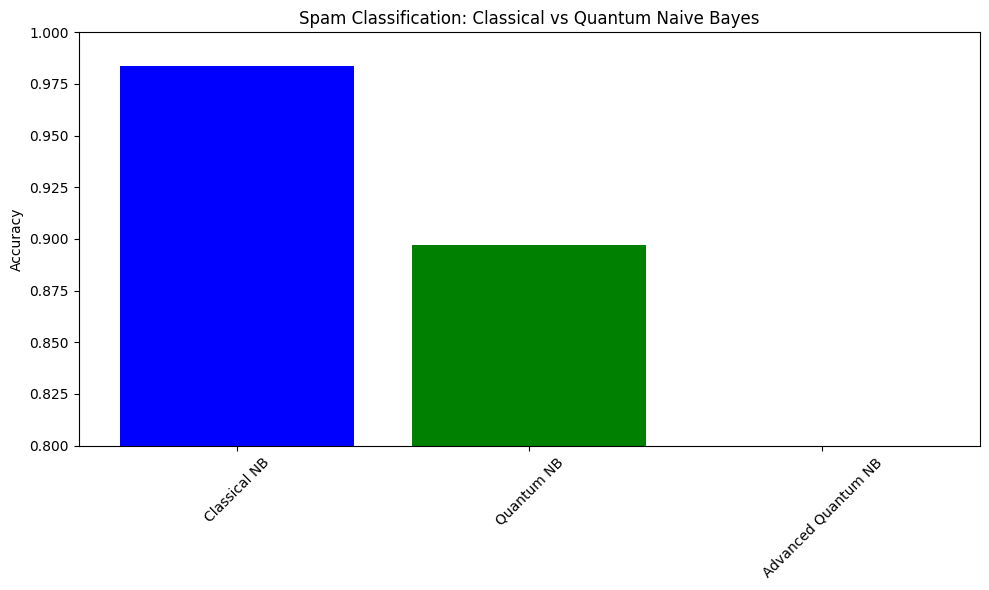

In [8]:
# Compare all models
results = {
    'Classical NB': accuracy_score(y_test, y_pred_classical),
    'Quantum NB': accuracy_score(y_test_q, y_pred_quantum),
    'Advanced Quantum NB': accuracy_score(y_test_q[:100], y_pred_adv)
}

print("\n=== COMPARATIVE RESULTS ===")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
models = list(results.keys())
accuracies = list(results.values())

plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylim(0.8, 1.0)
plt.title('Spam Classification: Classical vs Quantum Naive Bayes')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# simple_spam_app.py
import gradio as gr

def create_simple_spam_detector(classical_nb, classical_vectorizer, qnb, adv_qnb, vectorizer_quantum):
    """Ultra-simple spam detector - only SPAM/HAM output"""

    models = {
        'Classical': (classical_nb, classical_vectorizer),
        'Quantum': (qnb, vectorizer_quantum),
        'Advanced': (adv_qnb, vectorizer_quantum)
    }

    def predict(message, model_type):
        """Predict SPAM or HAM"""
        if not message.strip():
            return "Enter a message"

        try:
            model, vectorizer = models[model_type]

            if model_type == "Classical":
                X_input = vectorizer.transform([message])
            else:
                X_input = vectorizer.transform([message]).toarray()

            prediction = model.predict(X_input)[0]
            return "SPAM" if prediction == 1 else "HAM"

        except Exception as e:
            return f"Error: {str(e)}"

    # Simple interface
    iface = gr.Interface(
        fn=predict,
        inputs=[
            gr.Textbox(label="Message", lines=3, placeholder="Type your message here..."),
            gr.Radio(["Classical", "Quantum", "Advanced"], label="Model", value="Classical")
        ],
        outputs=gr.Textbox(label="Result"),
        title="SPAM DETECTOR",
        description="Check if a message is SPAM or HAM",
        examples=[
            ["Win $1000 now! Click here!", "Classical"],
            ["Hey, are we meeting tomorrow?", "Quantum"],
            ["Your account needs verification", "Advanced"]
        ]
    )

    return iface

if __name__ == "__main__":
    print("Starting Spam Detector...")

    # Load your models here
    # from your_training_code import classical_nb, vectorizer, qnb, adv_qnb, vectorizer_quantum

    # Create and launch
    app = create_simple_spam_detector(
        classical_nb=classical_nb,
        classical_vectorizer=vectorizer,
        qnb=qnb,
        adv_qnb=adv_qnb,
        vectorizer_quantum=vectorizer_quantum
    )

    app.launch(share=False)

Starting Spam Detector...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>